# NeuroEvolution - Homework 2 - DENSER-Like Algorithms

## Import Libraries

In [1]:
!pip install keras-tuner

In [2]:
from IPython.display import display, HTML
import cv2
import os
import random
import warnings 
import numpy as np
import pandas as pd
import seaborn
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.layers import BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import datasets, Sequential, layers, models, initializers, regularizers, optimizers, metrics, utils
from keras_tuner import RandomSearch
from tensorflow.keras.utils import load_img, img_to_array
from PIL import ImageFile
import tensorflow.keras.utils  as utils
from IPython.display import display
import pydot
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
# Data transformations for Mnist, Downloading and loading of train and test
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.MNIST(root='.', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

## Definition of the string-based genome

In [4]:
#Defining a string-based representation for the networks (the genotype)
layers_and_activations = [
    ('Linear', [('number_of_features', 1, 512), ('bias', 0.0, 1.0)]),
    ('BatchNorm1d', [('num_features', 1, 512),('eps', 1e-5, 1e-2), ('momentum', 0.1, 0.99)]),
    ('LayerNorm', [('normalized_shape', 1, 512), ('eps', 1e-5, 1e-2)]),
    ('Dropout', [('p', 0.0, 1.0)]),
    ('AlphaDropout', [('p', 0.0, 1.0)]),
    ('Activation', ['Sigmoid', 'ReLU', 'PReLU', 'ELU', 'SELU', 'GELU', 'CELU', 'SiLU']),
]


def select_random_params(layer_tuple):
    """
    Selects random parameters within the provided range for a given layer.
    """
    layer_name, param_list = layer_tuple
    random_params = []

    if layer_name == 'Activation':
        random_params.append(('function', random.choice(param_list)))
    else:
        for param_tuple in param_list:
            if isinstance(param_tuple[1], int):  
                random_value = random.randint(param_tuple[1], param_tuple[2])
            else:  
                random_value = random.uniform(param_tuple[1], param_tuple[2])
                random_value = round(random_value, 6)  

            random_params.append((param_tuple[0], random_value))

    return layer_name, random_params

## Defining a network class that is able to parse those instructions and build a functional pytorch network structure (the phenotype).

In [5]:
#Each network needs to have at least 1 layer and a maximum 50 layers. This choice
#needs to be made at random when generating the genotype.


class DeepNetwork:
    def __init__(self, genotype, phenotype):
        self.genotype = genotype
        self.phenotype = phenotype
    
    def set_genotype(self, genotype_value):
        self.genotype = genotype_value

    def set_phenotype(self, phenotype_value):
        self.phenotype = phenotype_value
    
    def generate_random_genotype(self, input_features, output_features):
        model_spec = []

        # Input layer
        layer_name, layer_params = select_random_params(layers_and_activations[0])
        layer_params_dict = dict(layer_params) 
        last_out_features = layer_params_dict['number_of_features']
        model_spec.append(('Linear', {'in_features': input_features, 'out_features': last_out_features}))

        # Hidden layers
        for i in range(random.randint(1, 48)):  # Choose a random number of layers to add ---- 48+2(2 = input+outpu)=50
            layer_choice = random.choice(layers_and_activations)
            layer_name, layer_params = select_random_params(layer_choice)
            layer_params_dict = dict(layer_params)
    
            if layer_name == 'Linear':
                current_in_features = last_out_features  
                last_out_features = layer_params_dict['number_of_features']  
                layer_params_dict = {'in_features': current_in_features, 'out_features': last_out_features}
            elif layer_name in ['BatchNorm1d']:
                layer_params_dict = {'num_features': last_out_features}
            elif layer_name in ['LayerNorm']:
                layer_params_dict = {'normalized_shape': last_out_features}
            model_spec.append((layer_name, layer_params_dict))
    
        # Output layer
        model_spec.append(('Linear', {'in_features': last_out_features, 'out_features': output_features}))
        self.genotype = model_spec
    
        return model_spec

    def genotype_to_phenotype(self, genotype):
        model = nn.Sequential()

        for i, (layer_name, layer_params) in enumerate(genotype):
            if layer_name == 'Activation':
                activation_function = getattr(nn, layer_params['function'])()
                model.add_module(f'Activation{i}', activation_function)
            else:
                layer = getattr(nn, layer_name)(**layer_params)
                model.add_module(f'{layer_name}{i}', layer)
        self.phenotype = model
        return model


input_size = 28*28

## Defining a string-based representation for the optimizer.

In [6]:
#Defining a string-based representation for the networks (the genotype)
optimizers = [
    ('Adam', [('lr', -3, -1), ('betas', (0.9, 0.999), (0.8, 0.99))]),
    ('AdamW', [('lr', -3, -1), ('betas', (0.9, 0.999), (0.8, 0.99)), ('weight_decay', -4, -1)]),
    ('Adadelta', [('lr', -3, -1), ('rho', 0.9, 0.99)]),
    ('NAdam', [('lr', -3, -1), ('betas', (0.9, 0.999), (0.8, 0.99)), ('momentum_decay', 0.003, 0.005)]),
    ('SGD', [('lr', -3, -1), ('momentum', 0.5, 0.99), ('nesterov', False, True)]),
]


def select_random_params_op(optimizer_tuple):
    """
    Selects random parameters within the provided range for a given optimizer.
    """
    optimizer_name, param_list = optimizer_tuple
    random_params = []

    for param_tuple in param_list:
        if param_tuple[0] == 'betas':  # the betas parameter is a tuple
            beta1 = random.uniform(param_tuple[1][0], param_tuple[1][1])
            beta2 = random.uniform(param_tuple[2][0], param_tuple[2][1])
            random_value = (beta1, beta2)
        elif param_tuple[0] == 'nesterov':  # boolean parameter
            random_value = random.choice([param_tuple[1], param_tuple[2]])
        elif param_tuple[0] == 'rho' or param_tuple[0] == 'momentum' or param_tuple[0] == 'momentum_decay':  # boolean parameter
            random_value = random.uniform(param_tuple[1], param_tuple[2])
        else:  # float parameter
            random_value = 10 ** random.uniform(param_tuple[1], param_tuple[2])
            random_value = round(random_value, 6)  # rounding to keep the number manageable

        random_params.append((param_tuple[0], random_value))

    return optimizer_name, random_params

# To test the functions
for optimizer in optimizers:
    print(f"{select_random_params_op(optimizer)}")

('Adam', [('lr', 0.023056), ('betas', (0.9949108781050736, 0.832511345056891))])
('AdamW', [('lr', 0.001052), ('betas', (0.9959042880687471, 0.8718309991252355)), ('weight_decay', 0.000298)])
('Adadelta', [('lr', 0.085064), ('rho', 0.9030256092482734)])
('NAdam', [('lr', 0.006547), ('betas', (0.936450026057432, 0.8059079656736282)), ('momentum_decay', 0.004030604160724907)])
('SGD', [('lr', 0.002572), ('momentum', 0.7520184063410011), ('nesterov', True)])


## Defining a way to parse those instructions and build and functional pytorch optimizer.

In [7]:
class DeepOptimizer:
    def __init__(self, genotype=None, phenotype=None):
        self.genotype = genotype
        self.phenotype = phenotype
    
    def set_genotype(self, genotype_value):
        self.genotype = genotype_value
        
    def set_random_genotype(self):
        # Choose a random optimizer
        optimizer_choice = random.choice(optimizers)

        # Get random parameters for the chosen optimizer
        optimizer_name, optimizer_params = select_random_params_op(optimizer_choice)
        optimizer_params_dict = dict(optimizer_params)  
    
        self.genotype = (optimizer_name, optimizer_params_dict)

    def set_phenotype(self, phenotype_value):
        self.phenotype = phenotype_value

    def genotype_to_phenotype(self, mp):
        optimizer = getattr(torch.optim, self.genotype[0])(mp, **self.genotype[1])
        self.phenotype = optimizer

## Defining the 4 genetic operators:
1. Network crossover
2. Add layer mutation
3. Remove layer mutation
4. Change optimizer mutation

In [8]:
def removelayer(indiv):
    g=indiv.genotype
    if len(g) <= 2:
        return print("genome is too short to have layers removed")
    else:
        r1 = random.randint(1, len(g)-2)
        it=0
        it2=r1+1
        while it < r1:
            if 'out_features' in g[it][1].keys():
                lastout=g[it][1]['out_features']
            it+=1
        while it2 < len(g):
            if (('in_features' in g[it2][1].keys()) or ('num_features' in g[it2][1].keys())):
                break
            else:
                it2+=1
        g[it2][1]['in_features']=lastout
        g.pop(r1)
    
    
def addlayer(indiv):
    g=indiv.genotype
    r1 = random.randint(1, len(g)-2)
    if len(g) >= 50:
        return print("genome is too long to have layers added")
    it=0
    it2=len(g)-1
    while it < r1:
        if 'out_features' in g[it][1].keys():
            lastout=g[it][1]['out_features']
        it+=1
    while it2 > r1:
        if 'in_features' in g[it2][1].keys():
            earliestin=g[it2][1]['in_features']
        it2-=1
    
    layer_choice = random.choice(layers_and_activations)
    layer_name, layer_params = select_random_params(layer_choice)
    layer_params_dict = dict(layer_params) 
    
    if layer_name == 'Linear':
        layer_params_dict = {'in_features': lastout, 'out_features': earliestin}
    elif layer_name in ['BatchNorm1d']:
        layer_params_dict = {'num_features': lastout}
    elif layer_name in ['LayerNorm']:
        layer_params_dict = {'normalized_shape': lastout}
    

def mutateoptimizer(opt, mp):
    g = opt.genotype
    
    #the size is the number of elements that exist for a given optimizer 
    #(1 is the name, the len of g[1] is the size of the dict)
    size = 1 + len(g[1]) 
    r1 = random.randint(0, size-1)
    rand_par = random.choice(list(g[1]))
    
    if r1 == 0:
        opt.set_random_genotype(opt)
    elif rand_par == 'betas':
        beta1 = random.uniform(0.9, 0.999)
        beta2 = random.uniform(0.8, 0.99)
        g[1][rand_par] = (beta1, beta2)
    elif rand_par == 'nesterov':
        g[1][rand_par] = random.choice([True, False])   
    elif rand_par == 'rho':
        g[1][rand_par] = random.uniform(0.9, 0.99)
    elif rand_par == 'momentum':
        g[1][rand_par] = random.uniform(0.5, 0.99)
    elif rand_par == 'momentum_decay':
        g[1][rand_par] = random.uniform(0.003, 0.005)
    else:
        g[1][rand_par] = 10 ** random.uniform(-3,1)
        g[1][rand_par] = round(g[1][rand_par], 6)
    opt.genotype_to_phenotype(opt,mp)
    
def crossover(indiv1, indiv2):
    g1 = indiv1.genotype
    g2 = indiv2.genotype
      
    crossover_point1 = random.randrange(1, len(g1)-1)
    crossover_point2 = random.randrange(1, len(g2)-1)
    
    newg1=[]
    newg1.append(g1[0])
    newg1+=g1[1:crossover_point1]+g2[crossover_point2:(len(g2)-1)]
    newg1.append(g1[len(g1)-1])
    
    newg2=[]
    newg2.append(g2[0])
    newg2+=g2[1:crossover_point2]+g1[crossover_point1:(len(g1)-1)]
    newg2.append(g2[len(g2)-1])    

    #####Contigency for crossover of newg1
    
    #Cycle for making sure the input of the first layer after crossover's has the output of the last output before crossover
    it=0
    while it < crossover_point1:
        if 'out_features' in newg1[it][1].keys():
            lastout=newg1[it][1]['out_features']
        it+=1
    it2=crossover_point1
    while it2 < len(newg1)-1:
        if 'in_features' in newg1[it2][1].keys():
            break
        elif ('num_features' in newg1[it2][1].keys()) or ('normalized_shape' in newg1[it2][1].keys()):
                if 'num_features' in newg1[it2][1].keys():
                    newg1[it2][1]['num_features']=lastout
                elif 'normalized_shape' in newg1[it2][1].keys():
                    newg1[it2][1]['normalized_shape']=lastout
        it2+=1
    
    if 'in_features' in newg1[it2][1].keys():
        newg1[it2][1]['in_features']=lastout
    elif 'num_features' in newg1[it2][1].keys():
        newg1[it2][1]['num_features']=lastout
    else:
        newg1[it2][1]['normalized_shape']=lastout
    
    #Cycle for making sure the input after the last layer of crossover's output is the same
       
    it=0
    while it < len(newg1)-1:
        if 'out_features' in newg1[it][1].keys():
            lastout2=newg1[it][1]['out_features']
        it+=1
    newg1[len(newg1)-1][1]['in_features']=lastout2
    
    #####Contigency for crossover of newg2
    it=0
    while it < len(newg2)-1:
        if 'out_features' in newg2[it][1].keys():
            lastout3=newg2[it][1]['out_features']
        it+=1
    newg2[len(newg2)-1][1]['in_features']=lastout3

    it=0
    while it < crossover_point2:
        if 'out_features' in newg2[it][1].keys():
            lastout4=newg2[it][1]['out_features']
        it+=1
    it2 = crossover_point2
    while it2 < len(newg2)-1 :
        if ('in_features' in newg2[it2][1].keys()):
            break
        elif ('num_features' in newg2[it2][1].keys()) or ('normalized_shape' in newg2[it2][1].keys()):
            if 'num_features' in newg2[it2][1].keys():
                newg2[it2][1]['num_features']=lastout4
            elif 'normalized_shape' in newg2[it2][1].keys():
                newg2[it2][1]['normalized_shape']=lastout4
        it2+=1
    
    if 'in_features' in newg2[it2][1].keys():
        newg2[it2][1]['in_features']=lastout4
    elif 'num_features' in newg2[it2][1].keys():
        newg2[it2][1]['num_features']=lastout4
    else:
        newg2[it2][1]['normalized_shape']=lastout4
            
    indiv1.set_genotype(newg1)
    indiv2.set_genotype(newg2)
    
    indiv1.genotype_to_phenotype(indiv1.genotype)
    indiv2.genotype_to_phenotype(indiv2.genotype)

## Experimental setup

### Initializing a population of Deep Networks and associated Optimizers

In [9]:
def initialize_population(genotype=None, phenotype=None):
    return ([DeepNetwork(None,None) for _ in range(5)])

def initialize_pop_op():
    return ([DeepOptimizer for _ in range(5)])

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()



pop=initialize_population(None, None)
pop_op=initialize_pop_op()

iter=0
for i in pop:
    i.generate_random_genotype(28*28,10)
    i.genotype_to_phenotype(i.genotype)
    abc=i.phenotype.parameters()
    indiv=pop_op[iter]
    indiv.set_random_genotype(indiv)
    indiv.genotype_to_phenotype(indiv, abc)
    iter+=1


In [ ]:
#Plotting the accuracies before applying the genetic operators

Model 0 Epoch 0  Accuracy 0.1244
Model 1 Epoch 0  Accuracy 0.1020
Model 2 Epoch 0  Accuracy 0.1017
Model 3 Epoch 0  Accuracy 0.1001
Model 4 Epoch 0  Accuracy 0.1004


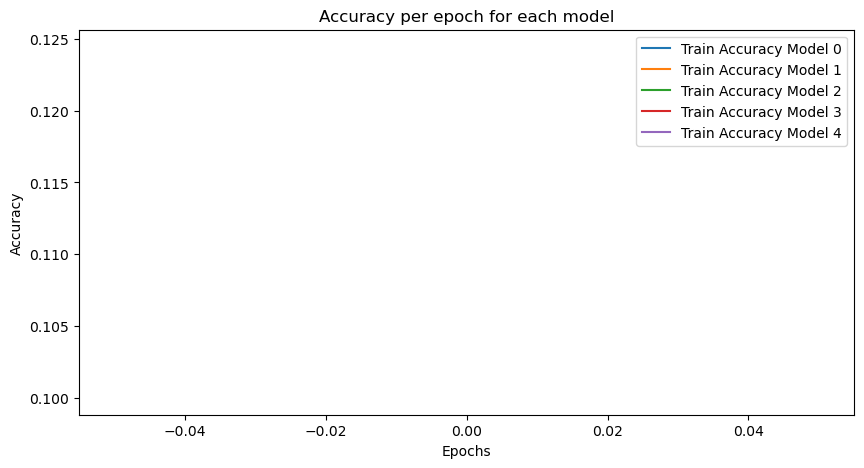

In [10]:
import matplotlib.pyplot as plt

loss_fn = nn.CrossEntropyLoss()
num_epochs = 50

# Initialize accuracy history for each model
accuracy_hist = {i: [] for i in range(len(pop))}

for model_index in range(len(pop)):
    model = pop[model_index].phenotype
    optimizer = pop_op[model_index].phenotype
    for epoch in range(num_epochs):
        accuracy_hist_train = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.view(x_batch.size(0), -1)  # flatten the input
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train += is_correct.sum()
        accuracy_hist_train /= len(train_loader.dataset)
        accuracy_hist[model_index].append(accuracy_hist_train)  # Save accuracy for this epoch
        print(f'Model {model_index} Epoch {epoch}  Accuracy {accuracy_hist_train:.4f}')

# Plot accuracy per epoch for each model
plt.figure(figsize=(10,5))
for model_index in range(len(pop)):
    plt.plot(accuracy_hist[model_index], label=f'Train Accuracy Model {model_index}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch for each model')
plt.legend()
plt.show()


In [11]:
### Performing the crossover on 2 parents, mutating one optimizer, removing a layer in a third network and adding a layer in a forth
crossover(pop[0], pop[1])
mutateoptimizer(pop_op[0], pop[0].phenotype.parameters())
removelayer(pop[2])
addlayer(pop[3])

In [ ]:
#Plotting the accuracies after applying the genetic operators

In [21]:
import matplotlib.pyplot as plt

loss_fn = nn.CrossEntropyLoss()
num_epochs = 50

# Initializing the accuracy history
accuracy_hist = {i: [] for i in range(len(pop))}

for model_index in range(len(pop)):
    model = pop[model_index].phenotype
    model.apply(weight_reset)
    optimizer = pop_op[model_index].phenotype
    for epoch in range(num_epochs):
        accuracy_hist_train = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.view(x_batch.size(0), -1)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train += is_correct.sum()
        accuracy_hist_train /= len(train_loader.dataset)
        accuracy_hist[model_index].append(accuracy_hist_train)
        print(f'Model {model_index} Epoch {epoch}  Accuracy {accuracy_hist_train:.4f}')

# Plotting the accuracies
plt.figure(figsize=(10,5))
for model_index in range(len(pop)):
    plt.plot(accuracy_hist[model_index], label=f'Train Accuracy Model {model_index}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch for each model')
plt.legend()
plt.show()


Model 0 Epoch 0  Accuracy 0.9010
Model 0 Epoch 1  Accuracy 0.9268
Model 0 Epoch 2  Accuracy 0.9348



KeyboardInterrupt

